Wczytano plik: master_dataset_project.csv
Trenowanie modelu Wzmocnienie Gradientowe...
--- WYNIKI (Wzmocnienie Gradientowe) ---
R2 Score: 0.9838
MAE: 22761
Zapisano tabelę: Wyniki_Wzmocnienie_Gradientowe\Prognoza_WG_2024.csv


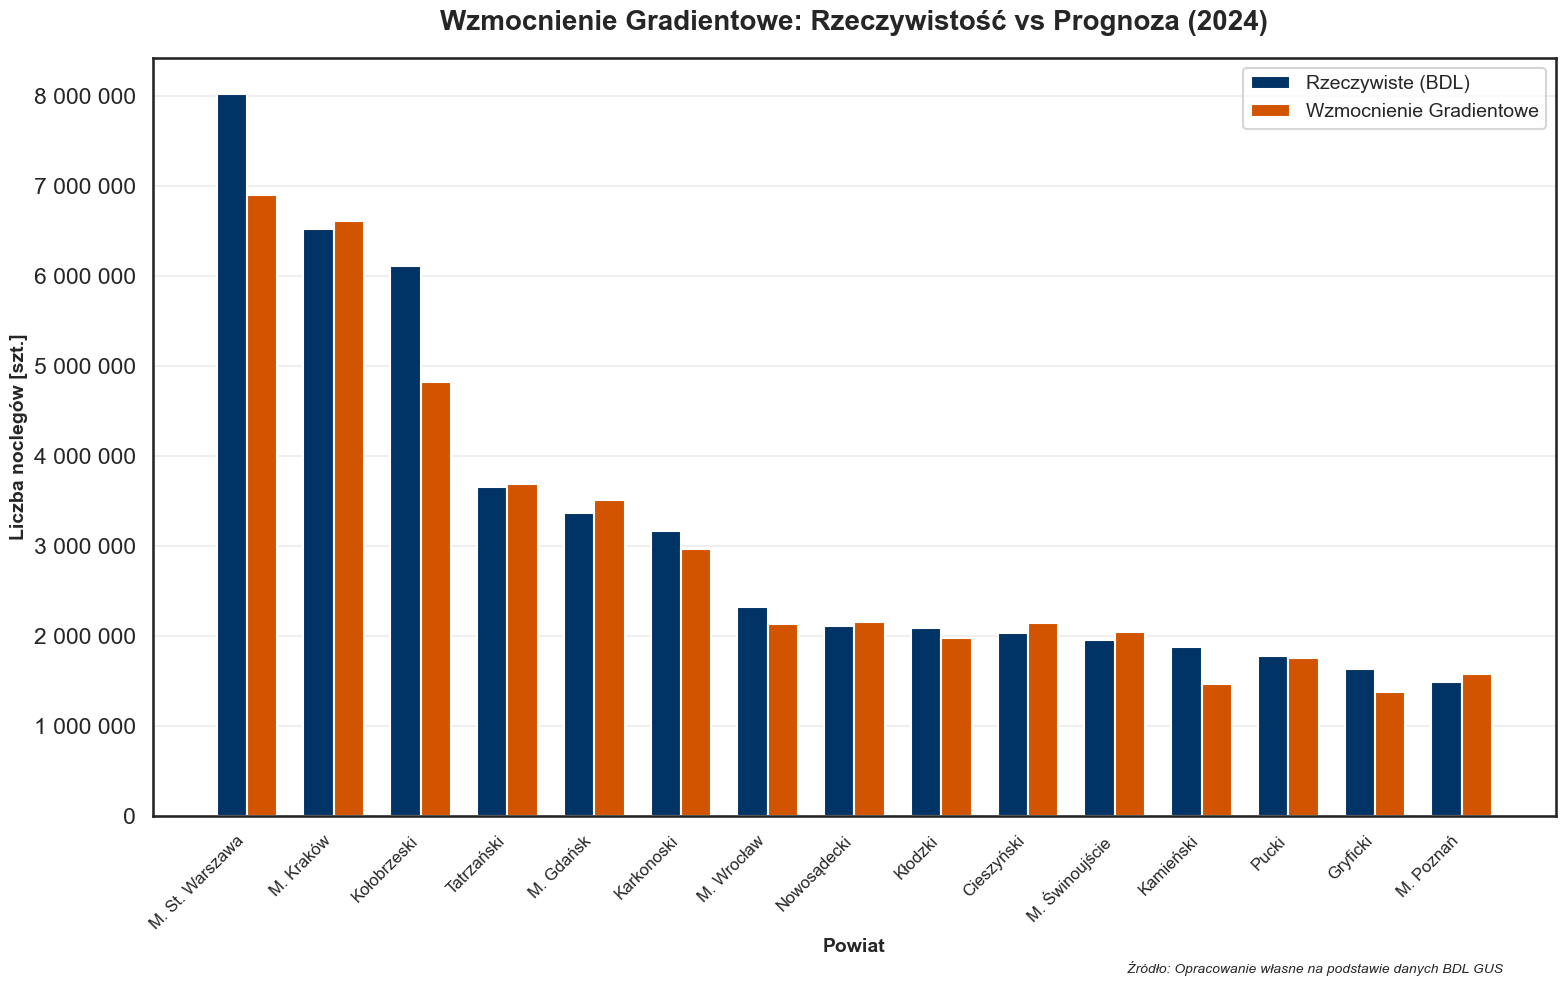

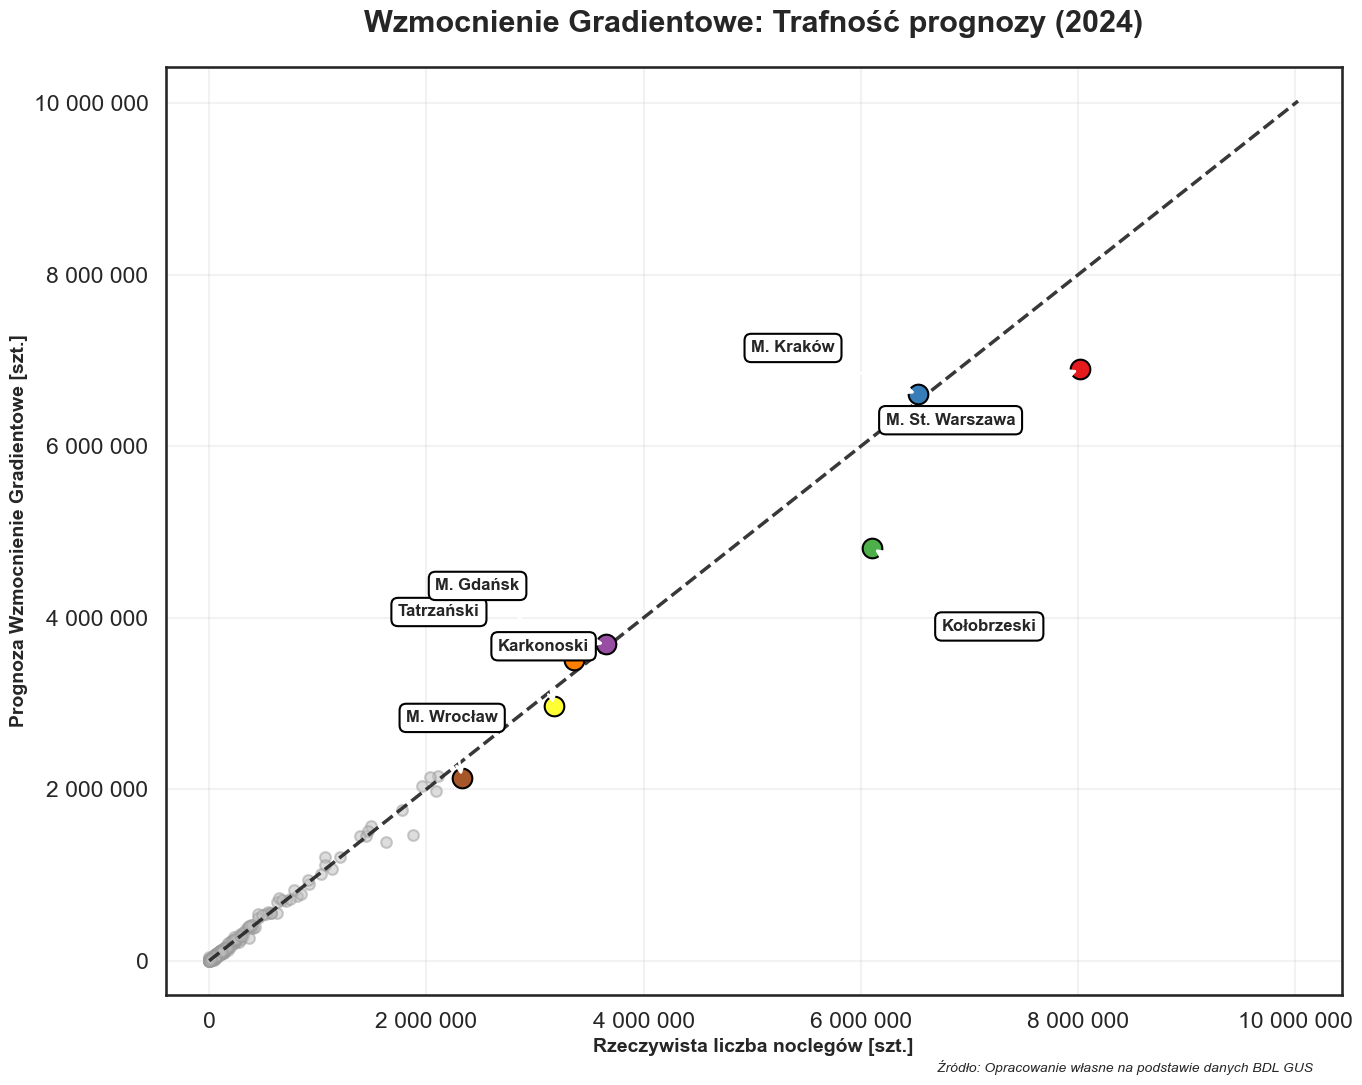

Gotowe! Wyniki zapisane w folderze: Wyniki_Wzmocnienie_Gradientowe


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import os

# --- KONFIGURACJA I STYLE ---
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'Arial'

# Nazwa folderu na wyniki (Polski nazwa metody)
output_folder = "Wyniki_Wzmocnienie_Gradientowe"
os.makedirs(output_folder, exist_ok=True)

# 1. WCZYTANIE DANYCH (Oryginalna tabela master)
file_name = "master_dataset_project.csv"

# Sprawdzenie ścieżki
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    print(f"Wczytano plik: {file_name}")
elif os.path.exists(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv"):
    df = pd.read_csv(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv")
else:
    raise FileNotFoundError("Brak pliku master_dataset_project.csv")

# Czyszczenie
df.columns = df.columns.str.strip()
df['Rok'] = pd.to_numeric(df['Rok'], errors='coerce')
df = df.dropna(subset=['Rok'])
df['Rok'] = df['Rok'].astype(int)
df['Nazwa'] = df['Nazwa'].str.title().str.replace("Powiat ", "")

# 2. PRZYGOTOWANIE CECH
df = df.sort_values(by=['Kod', 'Rok'])
# Lag (rok poprzedni)
df['Noclegi_LastYear'] = df.groupby('Kod')['Udzielone_Noclegi'].shift(1)
data_model = df.dropna(subset=['Noclegi_LastYear']).copy()

features = ['Rok', 'Liczba_Miejsc', 'Gestosc_Zaludnienia', 'Lesistosc_Proc', 'Noclegi_LastYear']
target = 'Udzielone_Noclegi'

# 3. PODZIAŁ: TRENING (2013-2023) vs TEST (2024 - Rzeczywiste dane z tabeli)
train_data = data_model[data_model['Rok'] < 2024].copy()
test_data = data_model[data_model['Rok'] == 2024].copy()

# 4. TRENOWANIE MODELU (Wzmocnienie Gradientowe)
print("Trenowanie modelu Wzmocnienie Gradientowe...")
model = GradientBoostingRegressor(n_estimators=150, random_state=42, learning_rate=0.1)
model.fit(train_data[features], train_data[target])

# Generowanie prognozy
predictions = model.predict(test_data[features])

# 5. ZAPIS WYNIKÓW
results = test_data[['Kod', 'Nazwa', target]].copy()
results.rename(columns={target: 'Rzeczywiste_2024'}, inplace=True)
results['Prognoza_WG_2024'] = predictions.astype(int)
results['Roznica'] = results['Prognoza_WG_2024'] - results['Rzeczywiste_2024']

# Obliczanie metryk
r2 = r2_score(results['Rzeczywiste_2024'], results['Prognoza_WG_2024'])
mae = mean_absolute_error(results['Rzeczywiste_2024'], results['Prognoza_WG_2024'])

print(f"--- WYNIKI (Wzmocnienie Gradientowe) ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.0f}")

# Zapis tabeli
csv_path = os.path.join(output_folder, "Prognoza_WG_2024.csv")
results.to_csv(csv_path, index=False, sep=';', encoding='utf-8-sig')
print(f"Zapisano tabelę: {csv_path}")

# =========================================================
# WIZUALIZACJA 1: Wykres Słupkowy (TOP 15)
# =========================================================
top_15 = results.sort_values(by='Rzeczywiste_2024', ascending=False).head(15)

plt.figure(figsize=(16, 10))
x = np.arange(len(top_15))
width = 0.35

plt.bar(x - width/2, top_15['Rzeczywiste_2024'], width, label='Rzeczywiste (BDL)', color='#003366')
plt.bar(x + width/2, top_15['Prognoza_WG_2024'], width, label='Wzmocnienie Gradientowe', color='#d35400') # Pomarańczowy

plt.xlabel('Powiat', fontsize=14, fontweight='bold')
plt.ylabel('Liczba noclegów [szt.]', fontsize=14, fontweight='bold')
plt.title(f'Wzmocnienie Gradientowe: Rzeczywistość vs Prognoza (2024)', fontsize=20, fontweight='bold', pad=20)
plt.xticks(x, top_15['Nazwa'], rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.grid(axis='y', alpha=0.3)

# Źródło
plt.figtext(0.95, 0.01, "Źródło: Opracowanie własne na podstawie danych BDL GUS", ha="right", fontsize=10, style='italic')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "WG_Wykres_Slupkowy.png"), dpi=300)
plt.show()

# =========================================================
# WIZUALIZACJA 2: Scatter Plot (Czysty ze strzałkami)
# =========================================================
plt.figure(figsize=(14, 11))

# Tło
plt.scatter(
    results['Rzeczywiste_2024'], 
    results['Prognoza_WG_2024'], 
    color='#bdbdbd', s=60, alpha=0.5, edgecolors='#999999',
    label='Pozostałe powiaty'
)

# Wyróżnienie TOP 7
top_points = results.sort_values(by='Rzeczywiste_2024', ascending=False).head(7)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
max_val = max(results['Rzeczywiste_2024'].max(), results['Prognoza_WG_2024'].max())

for i, (index, row) in enumerate(top_points.iterrows()):
    plt.scatter(
        row['Rzeczywiste_2024'], row['Prognoza_WG_2024'], 
        color=colors[i], s=200, edgecolors='black', linewidth=1.5, zorder=10
    )
    
    name = row['Nazwa']
    xytext_pos = (-40, 40)
    
    if "Warszawa" in name: xytext_pos = (-140, -40)
    elif "Kraków" in name: xytext_pos = (-120, 30)
    elif "Tatrzański" in name: xytext_pos = (-150, 20)
    elif "Kołobrzeski" in name: xytext_pos = (50, -60)
    elif "Gdańsk" in name: xytext_pos = (-100, 50)
    elif "Jeleniogórski" in name: xytext_pos = (-110, -40)
    elif "Nowosądecki" in name: xytext_pos = (40, 40)

    plt.annotate(
        name, xy=(row['Rzeczywiste_2024'], row['Prognoza_WG_2024']), 
        xytext=xytext_pos, textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle="->", linewidth=2.0, alpha=1.0),
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=1.0), zorder=20
    )

# Linia idealna
plt.plot([0, max_val * 1.25], [0, max_val * 1.25], '--', color='#222222', linewidth=2.5, alpha=0.9, label='Idealne dopasowanie')

plt.xlim(-max_val * 0.05, max_val * 1.3)
plt.ylim(-max_val * 0.05, max_val * 1.3)
plt.title("Wzmocnienie Gradientowe: Trafność prognozy (2024)", fontsize=22, fontweight='bold', pad=25)
plt.xlabel("Rzeczywista liczba noclegów [szt.]", fontsize=14, fontweight='bold')
plt.ylabel("Prognoza Wzmocnienie Gradientowe [szt.]", fontsize=14, fontweight='bold')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.grid(True, alpha=0.25)

# Źródło
plt.figtext(0.95, 0.01, "Źródło: Opracowanie własne na podstawie danych BDL GUS", ha="right", fontsize=10, style='italic')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "WG_Wykres_Punktowy.png"), dpi=300)
plt.show()

print(f"Gotowe! Wyniki zapisane w folderze: {output_folder}")

SUKCES! Wczytano plik z: C:\Nazar Haievskyj\Dane  w\master_dataset_project.csv
Trenowanie modelu Wzmocnienie Gradientowe...
--- WYNIKI (Wzmocnienie Gradientowe) ---
R2 Score: 0.9838
MAE: 22761
Zapisano tabelę: Wyniki_Wzmocnienie_Gradientowe\Prognoza_WG_2024.csv


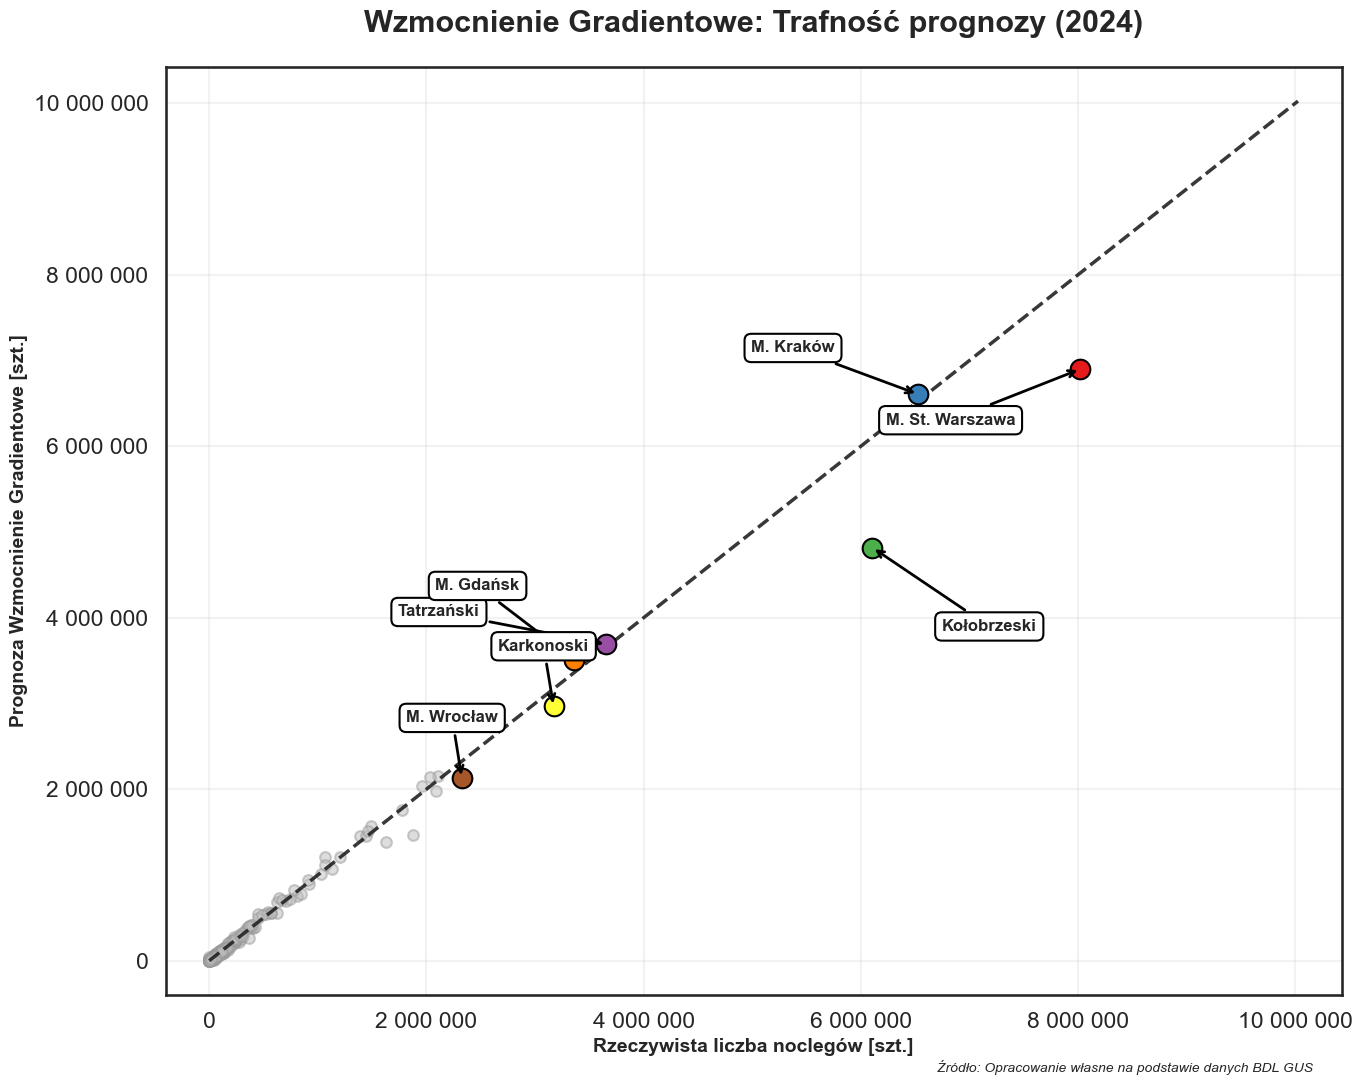

Gotowe! Wykres z czarnymi strzałkami zapisany w: Wyniki_Wzmocnienie_Gradientowe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import os

# --- KONFIGURACJA I STYLE ---
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'Arial'

# Nazwa folderu na wyniki
output_folder = "Wyniki_Wzmocnienie_Gradientowe"
os.makedirs(output_folder, exist_ok=True)

# 1. WCZYTANIE DANYCH (POPRAWIONE ŚCIEŻKI)
file_name = "master_dataset_project.csv"

# Lista potencjalnych ścieżek (sprawdzamy różne warianty spacji)
paths_to_check = [
    file_name, # W tym samym folderze co kod
    r"C:\Nazar Haievskyj\Dane  w\master_dataset_project.csv", # Dwie spacje
    r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv",  # Jedna spacja
    r"C:\Users\Nazar Haievskyj\Dane  w\master_dataset_project.csv" # Opcjonalnie z Users
]

df = None
loaded_path = ""

for path in paths_to_check:
    if os.path.exists(path):
        df = pd.read_csv(path)
        loaded_path = path
        break

if df is None:
    # Jeśli nadal nie działa, wypisz komunikat, gdzie szukaliśmy
    print("SZUKANO W LOKALIZACJACH:")
    for p in paths_to_check: print(f" - {p}")
    raise FileNotFoundError("Nie znaleziono pliku 'master_dataset_project.csv'. Sprawdź czy plik jest w folderze!")
else:
    print(f"SUKCES! Wczytano plik z: {loaded_path}")

# Czyszczenie danych
df.columns = df.columns.str.strip()
df['Rok'] = pd.to_numeric(df['Rok'], errors='coerce')
df = df.dropna(subset=['Rok'])
df['Rok'] = df['Rok'].astype(int)
df['Nazwa'] = df['Nazwa'].str.title().str.replace("Powiat ", "")

# 2. PRZYGOTOWANIE CECH
df = df.sort_values(by=['Kod', 'Rok'])
df['Noclegi_LastYear'] = df.groupby('Kod')['Udzielone_Noclegi'].shift(1)
data_model = df.dropna(subset=['Noclegi_LastYear']).copy()

features = ['Rok', 'Liczba_Miejsc', 'Gestosc_Zaludnienia', 'Lesistosc_Proc', 'Noclegi_LastYear']
target = 'Udzielone_Noclegi'

# 3. PODZIAŁ: TRENING vs TEST (2024)
train_data = data_model[data_model['Rok'] < 2024].copy()
test_data = data_model[data_model['Rok'] == 2024].copy()

# 4. TRENOWANIE MODELU (Wzmocnienie Gradientowe)
print("Trenowanie modelu Wzmocnienie Gradientowe...")
model = GradientBoostingRegressor(n_estimators=150, random_state=42, learning_rate=0.1)
model.fit(train_data[features], train_data[target])

# Generowanie prognozy
predictions = model.predict(test_data[features])

# 5. ZAPIS WYNIKÓW
results = test_data[['Kod', 'Nazwa', target]].copy()
results.rename(columns={target: 'Rzeczywiste_2024'}, inplace=True)
results['Prognoza_WG_2024'] = predictions.astype(int)
results['Roznica'] = results['Prognoza_WG_2024'] - results['Rzeczywiste_2024']

# Obliczanie metryk
r2 = r2_score(results['Rzeczywiste_2024'], results['Prognoza_WG_2024'])
mae = mean_absolute_error(results['Rzeczywiste_2024'], results['Prognoza_WG_2024'])

print(f"--- WYNIKI (Wzmocnienie Gradientowe) ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.0f}")

csv_path = os.path.join(output_folder, "Prognoza_WG_2024.csv")
results.to_csv(csv_path, index=False, sep=';', encoding='utf-8-sig')
print(f"Zapisano tabelę: {csv_path}")

# =========================================================
# WIZUALIZACJA: Scatter Plot (CZARNE STRZAŁKI)
# =========================================================
plt.figure(figsize=(14, 11))

# Tło
plt.scatter(
    results['Rzeczywiste_2024'], 
    results['Prognoza_WG_2024'], 
    color='#bdbdbd', s=60, alpha=0.5, edgecolors='#999999',
    label='Pozostałe powiaty'
)

# Wyróżnienie TOP 7
top_points = results.sort_values(by='Rzeczywiste_2024', ascending=False).head(7)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
max_val = max(results['Rzeczywiste_2024'].max(), results['Prognoza_WG_2024'].max())

for i, (index, row) in enumerate(top_points.iterrows()):
    plt.scatter(
        row['Rzeczywiste_2024'], row['Prognoza_WG_2024'], 
        color=colors[i], s=200, edgecolors='black', linewidth=1.5, zorder=10
    )
    
    name = row['Nazwa']
    xytext_pos = (-40, 40)
    
    if "Warszawa" in name: xytext_pos = (-140, -40)
    elif "Kraków" in name: xytext_pos = (-120, 30)
    elif "Tatrzański" in name: xytext_pos = (-150, 20)
    elif "Kołobrzeski" in name: xytext_pos = (50, -60)
    elif "Gdańsk" in name: xytext_pos = (-100, 50)
    elif "Jeleniogórski" in name: xytext_pos = (-110, -40)
    elif "Nowosądecki" in name: xytext_pos = (40, 40)

    # --- CZARNE STRZAŁKI ---
    plt.annotate(
        name, xy=(row['Rzeczywiste_2024'], row['Prognoza_WG_2024']), 
        xytext=xytext_pos, textcoords='offset points',
        # TUTAJ JEST ZMIANA KOLORU NA CZARNY:
        arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle="->", linewidth=2.0, alpha=1.0),
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=1.0), zorder=20
    )

# Linia idealna
plt.plot([0, max_val * 1.25], [0, max_val * 1.25], '--', color='#222222', linewidth=2.5, alpha=0.9, label='Idealne dopasowanie')

plt.xlim(-max_val * 0.05, max_val * 1.3)
plt.ylim(-max_val * 0.05, max_val * 1.3)
plt.title("Wzmocnienie Gradientowe: Trafność prognozy (2024)", fontsize=22, fontweight='bold', pad=25)
plt.xlabel("Rzeczywista liczba noclegów [szt.]", fontsize=14, fontweight='bold')
plt.ylabel("Prognoza Wzmocnienie Gradientowe [szt.]", fontsize=14, fontweight='bold')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.grid(True, alpha=0.25)

plt.figtext(0.95, 0.01, "Źródło: Opracowanie własne na podstawie danych BDL GUS", ha="right", fontsize=10, style='italic')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "WG_Wykres_Punktowy.png"), dpi=300)
plt.show()

print(f"Gotowe! Wykres z czarnymi strzałkami zapisany w: {output_folder}")